In [28]:
import shap
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pylab as pl
from graphviz import Digraph, Source
from pygraphviz import AGraph
import numpy as np
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
from flow import main, Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
import copy
import seaborn as sns
import scipy as sp
import scipy.cluster
from collections import defaultdict
import matplotlib.pyplot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [27]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)
X_display.head()

(32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


In [10]:
# use validation set to choose # of trees
params = {
    "eta": 0.002,
    "max_depth": 3,
    'objective':'binary:logistic',
    "subsample": 0.5
}
model = xgboost.train(params, xgb_train, 1000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-error:0.15461
[999]	test-error:0.15001


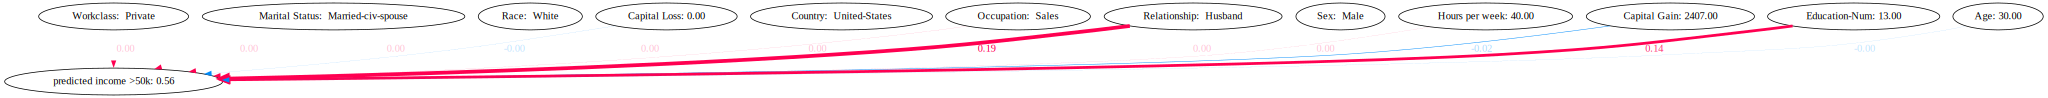

In [33]:
def build_graph(names, model, X, x, display_translator={}):
    '''
    build and return a graph (list of nodes), to be runnable in main
    '''
    # build the graph
    nodes = [Node(name) for name in names]
    nodes.append(Node('predicted income >50k', 
                      lambda *args: model.predict(xgboost.DMatrix(pd.DataFrame.from_dict(dict((name, [args[i]]) for i, name in enumerate(names)))))[0], 
                      nodes, is_target_node=True))
    
    def idx_f(idx, f):
        def f_():
            return f(idx)
        return f_
    
    graph = Graph(nodes,
                  dict((name, idx_f(i, lambda i: np.array(X)[np.random.choice(len(X))][i])) 
                       for i, name in enumerate(names)),
                  dict((name, idx_f(i, lambda i: np.array(x)[i])) 
                       for i, name in enumerate(names)),
                  display_translator)

    return graph

def target_translator(names, x, x_display):
    def f(a, b):
        def f_(val):
            if a == val: return b
            return a
        return f_
    
    res = {}
    x, x_display = list(x), list(x_display)
    for i, name in enumerate(names):
        res[name] = f(x[i], x_display[i])
    return res

sample_ind = 60 # 30
names = list(X.columns)
x = X.iloc[sample_ind]
x_display = X_display.iloc[sample_ind]
graph = build_graph(names, model, X, x, target_translator(names, x, x_display))
verbose = False #True
cf = CreditFlow(graph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str='{:.2f}')
viz_graph(G)
# save_graph(G, 'graph.png')

In [12]:
print(X.iloc[sample_ind])
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1], label=y[sample_ind:sample_ind+1])))
print('target:', model.predict(xgboost.DMatrix(X.iloc[sample_ind:sample_ind+1])))

Age                 30.0
Workclass            4.0
Education-Num       13.0
Marital Status       2.0
Occupation          12.0
Relationship         4.0
Race                 4.0
Sex                  1.0
Capital Gain      2407.0
Capital Loss         0.0
Hours per week      40.0
Country             39.0
Name: 60, dtype: float64
target: [0.56124014]
target: [0.56124014]


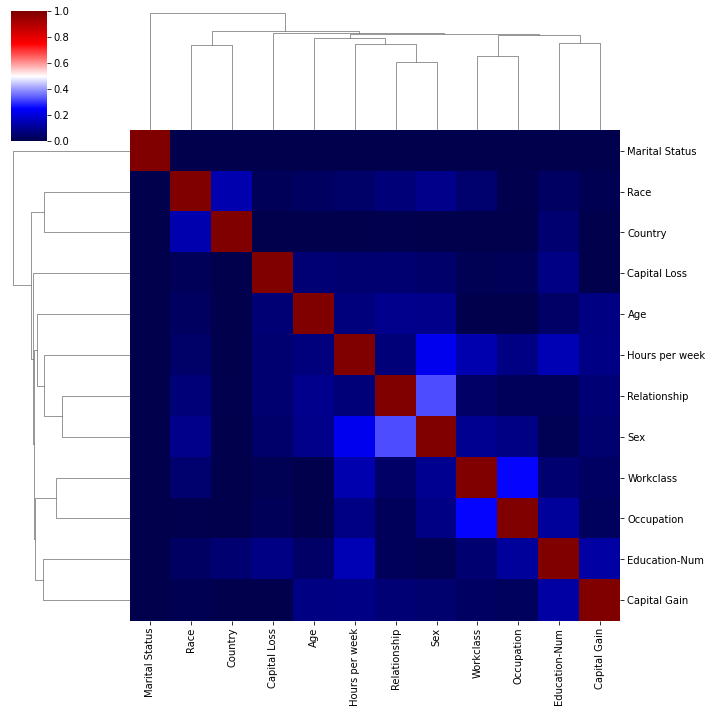

In [13]:
sns.clustermap(X.corr(), cmap='seismic', vmax=1, vmin=0)

In [18]:
X_display[['Relationship', 'Marital Status']]

,Relationship,Marital Status
0,Not-in-family,Never-married
1,Husband,Married-civ-spouse
2,Not-in-family,Divorced
3,Husband,Married-civ-spouse
4,Wife,Married-civ-spouse
...,...,...
32556,Wife,Married-civ-spouse
32557,Husband,Married-civ-spouse
32558,Unmarried,Widowed
32559,Own-child,Never-married


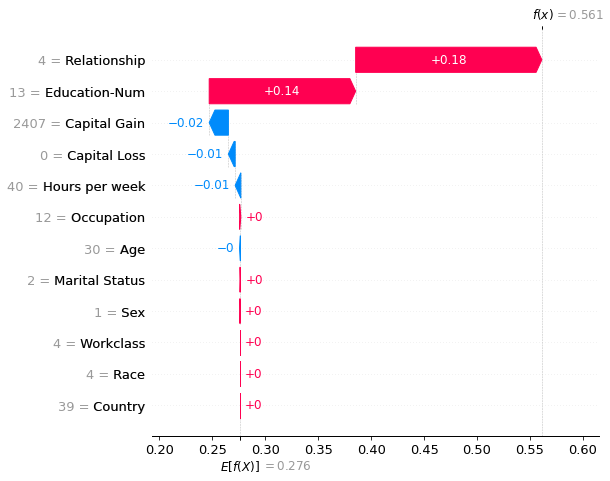

In [19]:
explainer = shap.SamplingExplainer(lambda x: model.predict(xgboost.DMatrix(x), validate_features=False), X, nsamples=10000) # nsamples=1000 * number of varying parameters
shap_values = explainer.shap_values(X.iloc[sample_ind:sample_ind+1])

shap.waterfall_plot(explainer.expected_value, shap_values[0], X.iloc[sample_ind], max_display=20)

In [22]:
print(X.columns)
graph.nodes

Index(['Age', 'Workclass', 'Education-Num', 'Marital Status', 'Occupation',
       'Relationship', 'Race', 'Sex', 'Capital Gain', 'Capital Loss',
       'Hours per week', 'Country'],
      dtype='object')


[Relationship,
 Occupation,
 Capital Gain,
 Sex,
 Workclass,
 Marital Status,
 Country,
 Race,
 Capital Loss,
 predicted income >50k,
 Education-Num,
 Hours per week,
 Age]

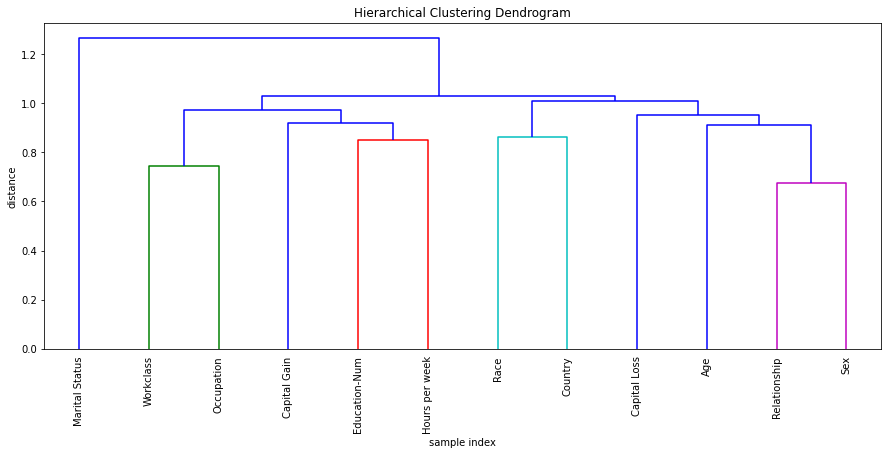

In [20]:
D = sp.spatial.distance.pdist(X.fillna(X.mean()).T, metric="correlation")
cluster_matrix = sp.cluster.hierarchy.complete(D)

# plot the clustering
pl.figure(figsize=(15, 6))
pl.title('Hierarchical Clustering Dendrogram')
pl.xlabel('sample index')
pl.ylabel('distance')
sp.cluster.hierarchy.dendrogram(
    cluster_matrix,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
    labels=X.columns
)
pl.show()

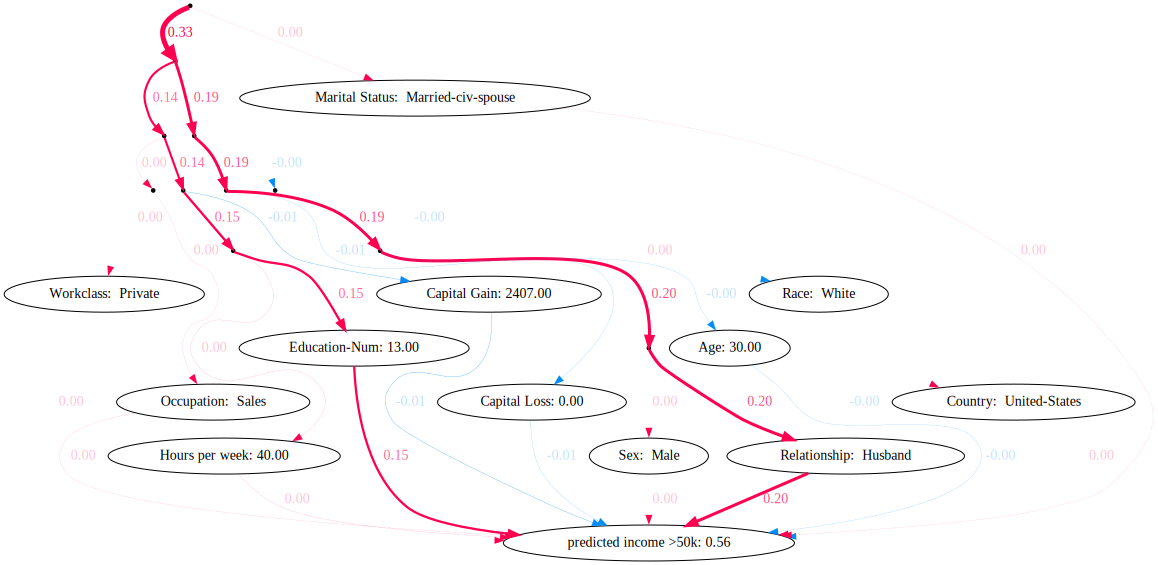

In [34]:
# sample_ind = 600 # 60 30 # interesting ones [300, 600]
# names = list(X.columns)
# x = X.iloc[sample_ind]
# x_display = X_display.iloc[sample_ind]
# graph = build_graph(names, model, X, x, target_translator(names, x, x_display))
hgraph = hcluster_graph(graph, list(X.columns), cluster_matrix)
verbose = False #True
cf = CreditFlow(hgraph, verbose=verbose, nruns=100, visualize=verbose)
cf.run()

G = cf.credit2dot(format_str='{:.2f}')
viz_graph(G)
# save_graph(G, 'graph.png')

# Learn relationships between features